#DQN

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque  #Deque is preferred over list in the cases where we need quicker append and pop operations
import numpy as np
import random
import torch.nn.functional as F
import copy
import math

In [ ]:
class replaybuffer():
  def __init__(self,buffer_size):
    self.buffer = deque(maxlen=buffer_size) #initilize deque that will store tuple
 
  def add_to_buffer(self,state,action,reward,next_state,done): #add new elements in buffer
    self.buffer.append({'state':np.array(state),"action":action,"reward":reward,"next_state":np.array(next_state),"done":done}) 
 
  def get_batch(self,batch_size): #return dictionary batch containing states,actions,rewards,next_states and dones tensor of specified batch size
    sample = random.sample(self.buffer,batch_size)#random selections of elements from buffer
    batch = {}
    for key in sample[0].keys():
      batch[key+'s']=torch.tensor([d[key] for d in sample])
    return batch
 
  def __len__(self):
    return len(self.buffer)

In [ ]:
try_buffer = replaybuffer(100)
state = env.reset()
done = False
while not done:
  action = env.action_space.sample()
  next_state,reward,done,_ = env.step(action)
  try_buffer.add_to_buffer(state,action,reward,next_state,done)
  state = next_state
try_buffer.buffer

In [ ]:
batch = try_buffer.get_batch(5)
batch

{'actions': tensor([1, 1, 0, 0, 1]),
 'dones': tensor([False, False, False, False, False]),
 'next_states': tensor([[-0.0735, -0.0459,  0.0996,  0.0676],
         [-0.0388, -0.4318,  0.0526,  0.5589],
         [-0.0714, -0.0487,  0.0971,  0.1307],
         [ 0.1362,  1.1096, -0.1327, -1.3613],
         [ 0.1584,  1.3061, -0.1599, -1.6924]], dtype=torch.float64),
 'rewards': tensor([1., 1., 1., 1., 1.]),
 'states': tensor([[-0.0687, -0.2395,  0.0930,  0.3296],
         [-0.0263, -0.6264,  0.0358,  0.8401],
         [-0.0744,  0.1477,  0.1010, -0.1920],
         [ 0.1102,  1.3034, -0.1003, -1.6211],
         [ 0.1362,  1.1096, -0.1327, -1.3613]], dtype=torch.float64)}

In [ ]:
class network(nn.Module):
  def __init__(self,input_size,output_size):
    super(network,self).__init__()
    self.fc1 = nn.Linear(input_size,24) #First hidden layer with 24 neurons
    self.fc2 = nn.Linear(24,24) #Second hidden layer with 24 neurons
    self.output_layer = nn.Linear(24,output_size) 
 
  def forward(self,input):
    out = F.relu(self.fc1(input))
    out = F.relu(self.fc2(out))
    out = self.output_layer(out)
 
    return out

In [ ]:
class DQN_Agent():
  def __init__(self,environment='CartPole-v0',learning_rate=0.001,start=0.9,end=0.005,decay=50,buffer_size = 10000):
    self.eps_start=start     #epsilon at start of episode
    self.eps_end=end         #epsilon at end of episode
    self.eps_decay=decay     #epsilon decay rate
    self.env = gym.make(environment)   
    self.q_net = network(self.env.observation_space.shape[0],self.env.action_space.n)  #initilize q network 
    self.target_net = copy.deepcopy(self.q_net)  # intilize target network
    self.Optimizer = optim.Adam(self.q_net.parameters(),lr=learning_rate ) 
    self.buffer = replaybuffer(buffer_size)  #intilize repaly buffer
    self.criterion = nn.MSELoss()

  def __select_action(self,state,episode): #selects action according to exploration-exploitation startegy
    eps = self.eps_end + (self.eps_start-self.eps_end)*math.exp(-1.*episode/self.eps_decay) #expoential epsilon decay
    state = torch.FloatTensor(state)
    if random.random() > eps:   
      with torch.no_grad():
        return torch.argmax(self.q_net(state)).item() 
    else :
      return torch.tensor([self.env.action_space.sample()]).item()
  
  def __learn(self,batch,gamma): #update network
    self.q_net.train()  
    rewards = batch['rewards'].reshape(len(batch['rewards']),1)  #Reshaping to 2D tensor
    max_next_state = torch.max(self.target_net(batch['next_states'].float()).detach(),dim=1,keepdim=True)[0]
    dones = (1-(batch['dones']).reshape(len(batch['dones']),1).to(torch.int8)) #batch['dones'] is boolen tensor, converting this to 2D int tensor
    next_q_values = rewards + gamma*max_next_state*dones
    actions = batch['actions'].reshape(len(batch['actions']),1).to(torch.int64) #converting to 2D tensor with dtype int64 because gather wants input as int64
    current_q_values = self.q_net(batch['states'].float()).gather(1,actions) #gather returns elements at indexes specified in action
    loss = self.criterion(current_q_values,next_q_values) #calculating loss
    self.Optimizer.zero_grad() 
    loss.backward()
    self.Optimizer.step()

  def train(self,episodes,print_every=200,gamma=0.99,batch_size=128,target_update=10):  #To train network
    for i in range(1,episodes+1):
      state = self.env.reset()   #resetting environment at starting of each episode
      done,total_reward,steps = False,0,0 
      while not done :
        action = self.__select_action(state,i) 
        next_state, reward,done,_ = self.env.step(action) 
        steps+=1
        if done and steps<200:  #if episode terminates before 200 steps
          reward = -1.0         #this will held network understand when it is taking wrong step
        self.buffer.add_to_buffer(state,action,reward,next_state,done) #storing transition tuple in buffer
        state = next_state
        total_reward+=reward
      if len(self.buffer)>batch_size:  
        self.__learn(self.buffer.get_batch(batch_size),gamma) #updating network
      if not i%target_update:  #update target network
        self.target_net.load_state_dict(self.q_net.state_dict()) 
      if not i%print_every :  
        if i==episodes:
          print("Finished training 🙌")
        else:
          print(f"Training...........Finished episode:{i} Total reward earned for this episode:{total_reward}")
          total_reward = 0
  
  def play(self): 
    state = self.env.reset()
    total_reward,done,steps = 0, False,0
    while True:    
      img = Image.fromarray( self.env.render(mode='rgb_array') )
      ipyd.clear_output(wait=True)
      ipyd.display(img)
      sleep(0.1) 
      if done:
        break
      action = torch.argmax(self.q_net(torch.tensor(state).float())).item()
      next_state, reward , done , _ = self.env.step(action)
      total_reward+=reward
      steps+=1 
      state = next_state
    print("Total reward:",total_reward)



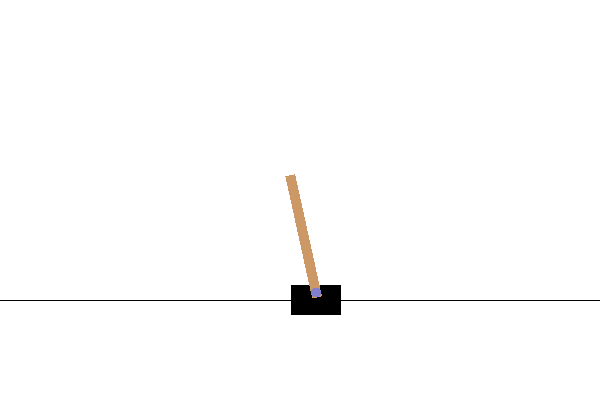

Total reward: 12.0


In [ ]:
agent = DQN_Agent()
agent.play()

In [ ]:
agent.train(episodes=5000)

Training...........Finished episode:200 Total reward earned for this episode:8.0
Training...........Finished episode:400 Total reward earned for this episode:16.0
Training...........Finished episode:600 Total reward earned for this episode:47.0
Training...........Finished episode:800 Total reward earned for this episode:36.0
Training...........Finished episode:1000 Total reward earned for this episode:26.0
Training...........Finished episode:1200 Total reward earned for this episode:64.0
Training...........Finished episode:1400 Total reward earned for this episode:42.0
Training...........Finished episode:1600 Total reward earned for this episode:35.0
Training...........Finished episode:1800 Total reward earned for this episode:56.0
Training...........Finished episode:2000 Total reward earned for this episode:48.0
Training...........Finished episode:2200 Total reward earned for this episode:200.0
Training...........Finished episode:2400 Total reward earned for this episode:200.0
Trainin

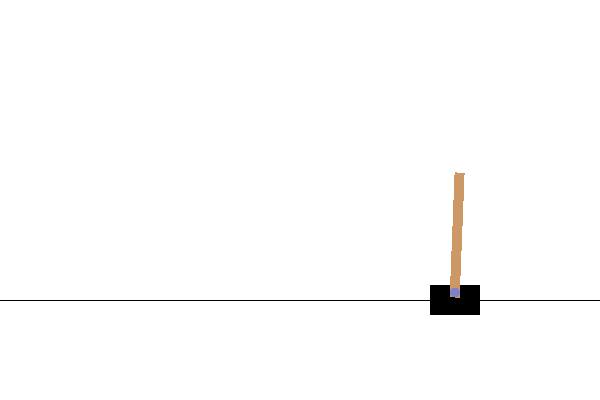

Total reward: 200.0


In [ ]:
agent.play()